# 2022 EY Data Science Challenge
## Model Building - Level 3

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|1    | Australia                     | Coarse (4km)  | 1 of 23 species  | TerraClimate                                                  |
| 2         | Australia, Costa Rica         | Moderate (1km) | 5 of 23 species       | TerraClimate, Sentinel-2                                      |
|***3***     | Australia, Costa Rica,<br>Europe | Fine (10m)   | 23 of all species       | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |


In this notebook, we will demonstrate a complex model workflow that can form a basis for developing a comprehensive solution to the challenge. As specified in the third row of the table above, this model will be trained on three international regions at the finest spatial resolution (10m x 10m), predicting all 23 target species against all available frog occurrence data. The model will be trained with all of the available data sources explored in the supplementary notebooks provided for the challenge, namely [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate), [Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a), [Land Cover](https://planetarycomputer.microsoft.com/dataset/group/io-land-cover), [JRC Global Surface Water](https://planetarycomputer.microsoft.com/dataset/jrc-gsw), and [Copernicus Digital Elevation](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30). We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 

Most of the functions present in this notebook were adapted from the following notebooks:
- [GBIF/Frog](Frogs.ipynb)
- [TerraClimate/Weather](Weather.ipynb)
- [Sentinel-2](Weather.ipynb)
- [Land Cover](Weather.ipynb)
- [JRC Global Surface Water](Weather.ipynb)
- [Copernicus Digital Elevation](Weather.ipynb)

`UPDATE LINKS^`

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think is best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Image processing
from scipy.ndimage import convolve

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio
import rioxarray as rio

import fsspec
# import xrspatial.multispectral as ms

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os

`jupyterhub --generate-config`

`jupyterhub --Spawner.mem_limit = '4G'`

### Gathering Frog Data

For this demonstration, we will constrain our search to frogs in the Greater Sydney area. This gives a varied landscape of bushland, plains, rivers, and urban areas.

Text(0.5, 1.0, 'Greater Sydney, NSW')

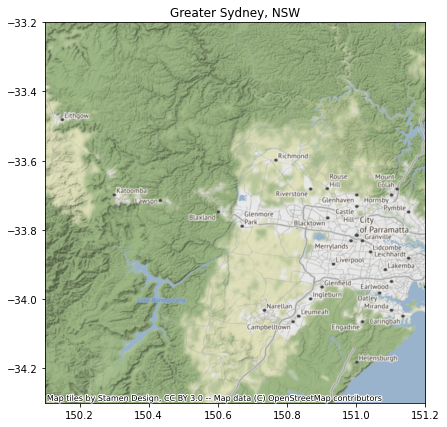

In [2]:
# Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Plot map of region
crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat], alpha=0)
cx.add_basemap(ax, crs=crs)
ax.set_title(region_name)

#### Fetching Frog Response Variable
Before we can build our model, we need to query the GBIF API to obtain the frog occurrence data for our region. If you have not checked out the [frog notebook](Frogs.ipynb) yet, we recommend you do before moving on so you can better understand the following functions. The code from that notebook is wrapped up in the `get_frogs` function defined below. This function will obtain all frog occurrences for the given region in the five years from the start of 2015 to the end of 2019. It returns a geopandas dataframe of each occurrence, its species, and its latitude and longitude coordinates. The challenge is to predict the habitats of the 23 species specified in the ['australian_frogs.csv'](australian_frogs.csv) file. Note that not all 23 will be present for a given area.

We will take all frog species to start, and will flag the 23 species of importance later.

In [4]:
def get_frogs(bbox, query_params, crs = {'init':'epsg:4326'}, orderKey="952", verbose=False):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""

    # Set query parameters
    min_lon, min_lat, max_lon, max_lat = bbox
    limit = 300
    offset = 0
    parameters = {
        **query_params,
        "orderKey":orderKey, # The order Anura (frogs) is indicated by key 952
        "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
        "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
        "limit":limit,
        "offset":offset
    }

    # Query API
    frogs = pd.DataFrame()
    while True:
        # Fetch results
        parameters['offset'] = offset
        response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
        total = response['count']

        # Print progress
        print(f"{offset} of {total}") if verbose else None

        # Add results to dataframe
        frogs = frogs.append(
            pd.DataFrame(response['results'])
            [["decimalLatitude", "decimalLongitude", "species", "speciesKey"]]
            .assign(
                occurrenceStatus = 1
            )
        )
        if response['endOfRecords']:
            break
        offset += limit

    geo_frogs = gpd.GeoDataFrame(
        frogs.reset_index(drop=True), 
        geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
        crs=crs
    )
    return geo_frogs

In [5]:
# Pass in the date range to the GBIF API
gbif_api_params = {"year":"2015,2019"}

# Get frogs!
# all_frog_data = get_frogs_by_species(bbox, frog_species.speciesKey, frog_species.species, gbif_api_params, verbose=False)
# all_frog_data.to_csv('all_frogs_GWS_2015_2019.csv', index=None)
all_frog_data = pd.read_csv('all_frogs_GWS_2015_2019.csv')
all_frog_data.sample(10, random_state=420)

,decimalLatitude,decimalLongitude,species,speciesKey,occurrenceStatus
27642,-33.849395,151.078029,Litoria peronii,2427831.0,1
25279,-33.987971,150.911086,Pseudophryne bibronii,2424568.0,1
6214,-34.143000,150.986000,Ranoidea phyllochroa,10754639.0,1
13945,-33.476900,150.173000,Crinia signifera,2424585.0,1
23288,-34.168621,150.589691,Limnodynastes peronii,2429583.0,1
358,-33.893583,151.112373,Limnodynastes peronii,2429583.0,1
3724,-33.905132,151.146538,Limnodynastes peronii,2429583.0,1
8611,-33.839704,151.067810,Litoria fallax,2427671.0,1
4368,-33.770660,151.041873,Limnodynastes peronii,2429583.0,1
9092,-33.841330,151.062345,Litoria fallax,2427671.0,1


Now we need to specify the response variable for our model. This will be the species name if it is one of the 23 species of interest, and 'other' if otherwise. 

In [6]:
# Read in species data
frog_species = pd.read_csv('australian_frogs.csv')

# Create response variable
frog_data = (
    all_frog_data
    # Convert species key to integer
    .assign(
        speciesKey = lambda x: np.where(x.speciesKey.isna(), 0, x.speciesKey).astype(int)
    )
    .merge(
        frog_species[['speciesKey', 'species']],
        on='speciesKey',
        how='left'
    )
    .assign(
        species = lambda x: np.where(x.species_y.isna(), 'Other', x.species_y)
    )
    .drop(['species_x', 'species_y'], 1)
)
frog_data

,decimalLatitude,decimalLongitude,speciesKey,occurrenceStatus,species
0,-33.922120,150.971745,2427671,1,Litoria fallax
1,-33.838575,151.071142,2429583,1,Other
2,-33.838575,151.071142,2427831,1,Other
3,-33.836398,151.059792,10595763,1,Other
4,-33.838673,151.069184,10595763,1,Other
...,...,...,...,...,...
28091,-33.500000,150.700000,0,1,Other
28092,-33.500000,150.700000,2424624,1,Other
28093,-33.613270,150.746130,10857682,1,Nyctimystes infrafrenatus
28094,-33.637376,150.810455,10842219,1,Other


Below, we can visualise the frog species distribution of the area. Here, only seven of the 23 are present and crinia signifera, the common eastern froglet, is the most common species.

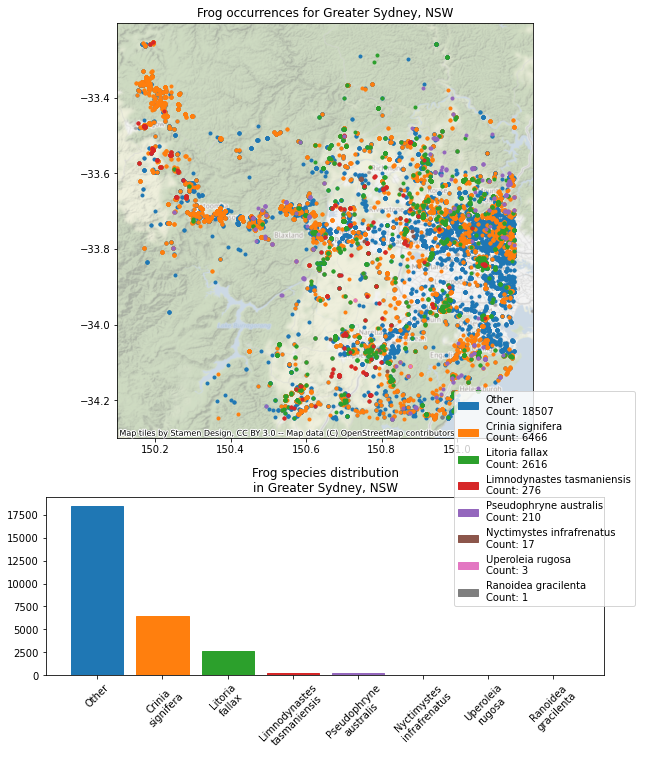

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (10, 12), gridspec_kw={'height_ratios':[0.7, 0.3]})

# Bar chart
bar_data = frog_data.species.value_counts()
barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

# Colour cycle to ensure colors match in both plots
prop_cycle = plt.rcParams['axes.prop_cycle']
for i, color in zip(range(len(bar_data)), prop_cycle):
    species_name = bar_data.index[i]
    barchart[i].set_color(color['color'])
    barchart[i].set_label(f"{species_name}\nCount: {bar_data[i]}")
    filt = frog_data.species == species_name
    # Scatter plot
    ax[0].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, marker='.', color=color['color'])

# Add other features
ax[0].set_title(f"Frog occurrences for {region_name}")
ax[1].set_title(f"Frog species distribution\nin {region_name}")
cx.add_basemap(ax[0], crs=crs, alpha=0.5) # Add basemap
plt.xticks(rotation=45)
fig.legend(loc=(0.70, 0.2))
plt.show()

### Pseudo-absence

The scatterplot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge. 

One method of addressing the sampling bias inherent in the database is to focus on predicting each species, and to use the occurrence points of other species as absence points. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.


### Class Balancing

Another issue shown clealy in the barchart is the class imbalance of the frog species. Of the 23 species, only seven of them are present in this area for the given time window, and three of the seven have less than 20 observations. For this demonstration, we will drop these three species, down sample the 'Other' class, and up-sample each of the minority classes to match that of crinia signifera. This is quite a naive approach, so you are encouraged to pursue other more thoughtful ways of addressing this issue.


Other
Crinia signifera
Litoria fallax
Limnodynastes tasmaniensis
Pseudophryne australis


<AxesSubplot:title={'center':'Frog Species After Balancing'}>

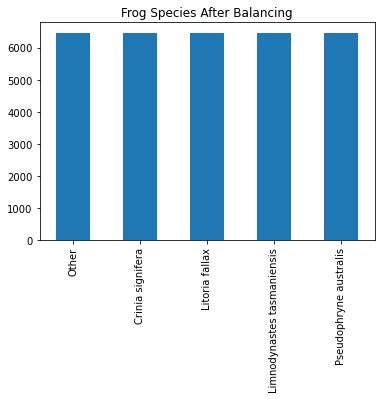

In [8]:
target_counts = bar_data[1]

balanced_frogs = pd.DataFrame()

for species, counts in zip(bar_data.index[0:5], bar_data[0:5]):
    print(species)
    balanced_frogs = balanced_frogs.append(
        frog_data
        [lambda x: x.species == species]
        .sample(target_counts, random_state=420, replace=True)
    )

# Assign index as key
balanced_frogs = balanced_frogs.reset_index(drop=True).assign(key=lambda x: x.index)
    
balanced_frogs.species.value_counts().plot(kind='bar', title='Frog Species After Balancing')

After balancing the classes, we finally have our training data visualised below. Again, it must be stressed that this is just one way of addressing the sampling bias inherent in the GBIF data and it does not address the bias completely. Since we will be using this training dataset for evaluation, the evaluation metrics will also contain bias. You are encouraged to improve the training set collection process, particularly the frog absence sampling, until you are confident in its ability to accurately train and evaluate your model. For now, we will continue with this training set.

Text(0.5, 1.0, 'Training set for Greater Sydney, NSW')

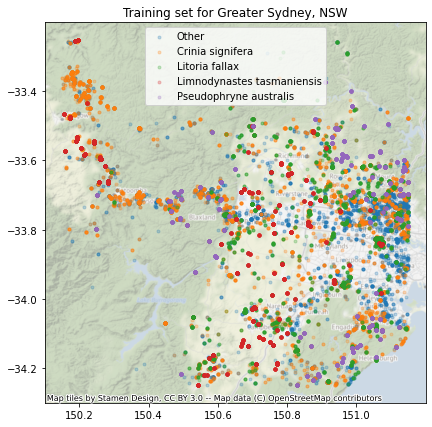

In [9]:
fig, ax = plt.subplots(figsize = (7, 7))

for species in balanced_frogs.species.unique():
    filt = balanced_frogs.species == species
    ax.scatter(balanced_frogs[filt].decimalLongitude, balanced_frogs[filt].decimalLatitude,
        label=species, marker='.', alpha=0.25)

ax.legend()
cx.add_basemap(ax, crs=crs, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

### Fetching predictor variables




To assist with performance, we will store predictor variables in geotiff files with the `save_to_geotiff` function defined below.

In [10]:
def save_to_geotiff(arr, filename, bbox):
    # If filename is specified, save mosaic to geotiff  
    bands = arr.shape[0]
    height = arr.shape[1]
    width = arr.shape[2]
        
    # Attach bandnames onto filename 
    filename = filename + '_' + ','.join(arr.band.values) + '.tiff'
    
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
    # Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
    gt = rasterio.transform.from_bounds(min_lon, min_lat, max_lon, max_lat, width, height)
    arr.rio.write_crs("epsg:4326", inplace=True)
    arr.rio.write_transform(transform=gt, inplace=True);
    
    # Create the GeoTIFF output file using the defined parameters
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height, crs='epsg:4326',
                       transform=gt, count=bands, compress='lzw', dtype='uint16') as dst:
        for band in range(bands):
            print(f'writing {band+1} of {bands}')
            dst.write(arr[band],band+1)
        dst.close()

#### TerraClimate

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take six metrics from four assets, namely the mean and overall maximum monthly air temp (`tmax_mean`, `tmax_max`), mean and overall minimum monthly air temp (`tmin_mean`, `tmin_min`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

Because the TerraClimate data has a comparitively lower spatial resolution to the other satellite data, we will need to interpolate this data to match the higher resolution data. To achieve this, the `get_terraclimate` function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates. 

In [11]:
def get_terraclimate(bbox, filename=None, metrics={'mean':{'fn':np.nanmean,'params':{}}}, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area (or None if filename specified), allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    filename -- string or None. If None, will save result to geotiff. 
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
        
    if filename is not None:
        save_to_geotiff(combined_data, filename, bbox)
        return None
    
    return combined_data

Next, we write a function called `get_pc` that will assist us in grabbing each predictor variable from the planetary computer. It will calculate the median mosaic and return it as an xarray object.

In [12]:
# Function to access the planetary computer
def get_pc(product, bbox, assets={"image/tiff"}, resolution=10, pc_query=None, date_range=None, na_val=None, filename=None):
    """Return the median mosaic xarray of a specified planetary computer product for a given location
    
    Attributes:
    product -- string representing the planetary computer product
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    assets -- list of assets to take from the product
    resolution -- resolution in meters
    pc_query -- dictionary of arguments to pass to the planetary computer
    date_range -- string representing the date range of the query e.g. '2020-01-01/2020-12-31'
    na_val -- the value representing na values in the dataset. Will be ignored in median calculation
    filename -- string or None. If None, will save result to geotiff.
    """
    
    # Query the planetary computer
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print('This is the number of scenes that touch our region:',len(items))
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    if na_val is not None:
        data = data.where(lambda x: x != na_val, other=np.nan)
    
    # Median Composite
    median = data.median(dim="time", skipna=True)
    
    # Rename bands of those with only one band (which otherwise defaults to generic 'data')
    if median.shape[0] == 1:
        median = median.assign_coords(band=[product])
    
    if filename is not None:
        save_to_geotiff(median, filename, bbox)
        return None
    
    return median.compute()

The elevation data is the only dataset we are going to pull from the planetary computer that has a spatial resolution greater than 10m, it being 30m. Luckily, the `stackstac.stack` function has interpolation built into it, so all planetary computer products will be returned with the same dimensions. 

Additionally, we will calculate the slope from the elevation data. To do this, we define the `slope_pct` function to apply over the elevation data.

In [13]:
def slope_pct(dem, resolution):
    # Kernel for rate of elevation change in x-axis.
    dx_kernel = np.array([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])
    # Kernel for rate of elevation change in y-axis.
    dy_kernel = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])
    # Rate of change calculations for each axis.
    dx = convolve(dem, dx_kernel) / (8 * resolution)
    dy = convolve(dem, dy_kernel) / (8 * resolution)
    # Return rise/run * 100 for slope percent.
    return np.sqrt(np.square(dx) + np.square(dy)) * 100

In [14]:
def save_predictor_datasets(products, bbox, path, interp_dims=(512, 512), product_names={"cop-dem-glo-30":'elevation', "io-lulc":'landcover', 'jrc-gsw':'surface_water', 'sentinel-2-l2a':'sentinel-2'}):
    """collect and download all products"""
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}')
        
        # Interpolate the weather data to 10m resolution
        if product == 'terraclimate':
            get_terraclimate(bbox, filename=path+product, interp_dims=interp_dims, **params)
        elif product == 'cop-dem-glo-30':
            # Don't specify filename so that the array is returned and we can calculate the slope
            data = get_pc(product, bbox, **params)
        else:
            get_pc(product, bbox, filename=path+product, **params)

        # Calculate the gradient of the elevation data
        if product == 'cop-dem-glo-30':
            data_elevation = data.squeeze().drop("band")
            slope_vals = slope_pct(data_elevation, products[product]['resolution'])
            data_slope = xr.DataArray(
                np.expand_dims(slope_vals, 0),
                coords=dict(
                    band=['gradient'],
                    y=data_elevation.y,
                    x=data_elevation.x
                )
            )
            save_to_geotiff(data, path+product, bbox)
            save_to_geotiff(data_slope, path+product+'_slope', bbox)
    
    
# Define products and query parameters for the planetary computer
products = {
    # Elevation
    "cop-dem-glo-30":{
        "resolution":10
    },
    # Land Cover
    "io-lulc":{
        "resolution":10
    },
    # Water extent data
    'jrc-gsw':{
        "resolution":10
    },
    # Sentinel-2 Spectral Band data
    'sentinel-2-l2a':{
        "resolution":10,
        'assets':["B04", "B03", "B02", "B08"],
        'pc_query':{"eo:cloud_cover": {"lt": 0.01}}, # Restrict to only the clearest images (otherwise takes too long to load). This one takes ~10mins
        'date_range':'2015-01-01/2019-12-31',
        'na_val':0
    },
    # Weather - might need to adjust x_dim, y_dim params to match dimensions of dataarrays above. Off by one errors common.
    "terraclimate":{
        'metrics':{
            'mean':{
                'fn':np.nanmean,
                'params':{}
            },
            'min':{
                'fn':np.nanmin,
                'params':{}
            },
            'max':{
                'fn':np.nanmax,
                'params':{}
            }
        },
        'time_slice':('2015-01-01','2019-12-31'),
        'assets':['tmax', 'tmin', 'ppt', 'soil'],
        'features':['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']
    }
}

# folder to store geotiffs in
path = './data/'

# convert degrees to pixels for crs=4326 
x_dim = int((max_lon - min_lon)*111320.0/10 + 1)
y_dim = int((max_lat - min_lat)*111320.0/10)            

# save_predictor_datasets(products, bbox, path, interp_dims=(x_dim, y_dim))

In [15]:
!ls data/*.tiff -lah

-rw-rw-r-- 1 billy billy 115M Jan 24 05:40 data/cop-dem-glo-30_cop-dem-glo-30.tiff
-rw-rw-r-- 1 billy billy 100M Jan 24 05:40 data/cop-dem-glo-30_slope_gradient.tiff
-rw-rw-r-- 1 billy billy  12M Jan 24 05:41 data/io-lulc_io-lulc.tiff
-rw-rw-r-- 1 billy billy  89M Jan 24 05:42 data/jrc-gsw_change,extent,occurrence,recurrence,seasonality,transitions.tiff
-rw-rw-r-- 1 billy billy 307M Jan 24 05:53 data/sentinel-2-l2a_B04,B03,B02,B08.tiff
-rw-rw-r-- 1 billy billy 214M Jan 24 05:54 data/terraclimate_tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean.tiff


In [16]:
all_datasets = []
for file in os.listdir(path):
    bands = '_'.join(file[:-5].split('_')[1::]).split(',')
    all_datasets.append(
        xr.open_rasterio(path+file).assign_coords(band=bands)
    )

#### Stitching together all predictor variables

In [17]:
def create_predictor_image(all_datasets):
    """Returns one xarray with concatenated bands

    Arguments:
    all_datasets -- list of xarrays of dimensions, where the ith array has dimensions (k_i, n, m). 
    """
    # Combine datasets into one multi-band image
    for i, data in enumerate(all_datasets):
        print(f"Combining dataset {i+1} of {len(all_datasets)}")
                
        if i == 0:
            combined_values = data.values
            combined_bands = data.band.values
            x_coords = data.x
            y_coords = data.y
            dims = data.dims
        else:
            combined_values = np.concatenate((combined_values, data.values), axis=0)
            combined_bands = np.concatenate((combined_bands, data.band.values))

    predictor_image = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            x=x_coords,
            y=y_coords
        )
    )
    return predictor_image

In [18]:
predictor_image = create_predictor_image(all_datasets)
predictor_image.band.values

Combining dataset 1 of 6
Combining dataset 2 of 6
Combining dataset 3 of 6
Combining dataset 4 of 6
Combining dataset 5 of 6
Combining dataset 6 of 6


array(['io-lulc', 'slope_gradient', 'B04', 'B03', 'B02', 'B08', 'change',
       'extent', 'occurrence', 'recurrence', 'seasonality', 'transitions',
       'tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean',
       'soil_mean', 'cop-dem-glo-30'], dtype='<U14')

##### Joining Features to Response Variable

Now that we have read in both our response and predictor variables, we now need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [20]:
def join_features(model_data, predictor_image):
    """Joins the features from each feature dataset onto each response variable. 

    Arguments:
    model_data -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    all_datasets -- list of feature datasets stored as xarray dataarrays, indexed with geocoordinates
    """
    # For each latitude and longitude coordinate, find the nearest predictor variable pixel values
    data_per_point = pd.DataFrame()
    for j, (lon, lat, key) in enumerate(zip(model_data.decimalLongitude, model_data.decimalLatitude, model_data.key)):
        # Print out some progress markers
        if (j+1)%500==0:
            print(f"{j+1} of {len(model_data)}")

        # Get the predictor pixel at the site of the frog occurrence
        nearest_point = predictor_image.sel(x=lon, y=lat, method="nearest")

        # Prepare values and columns and save them in a dataframe, saving the join key for later reference
        values = np.concatenate((np.squeeze(nearest_point.values), np.array([key])))
        columns = list(nearest_point.band.values) + ['key']
        data_per_point = data_per_point.append(
            pd.DataFrame(
                np.array([values]), 
                columns=columns
            )
        )

    # Join the predictor variables we just collected back onto the frog data
    model_data = model_data.merge(
        data_per_point,
        on = ['key'],
        how = 'inner'
    )
        
    return model_data

model_data = join_features(balanced_frogs, predictor_image)
model_data.head()

500 of 32330
1000 of 32330
1500 of 32330
2000 of 32330
2500 of 32330
3000 of 32330
3500 of 32330
4000 of 32330
4500 of 32330
5000 of 32330
5500 of 32330
6000 of 32330
6500 of 32330
7000 of 32330
7500 of 32330
8000 of 32330
8500 of 32330
9000 of 32330
9500 of 32330
10000 of 32330
10500 of 32330
11000 of 32330
11500 of 32330
12000 of 32330
12500 of 32330
13000 of 32330
13500 of 32330
14000 of 32330
14500 of 32330
15000 of 32330
15500 of 32330
16000 of 32330
16500 of 32330
17000 of 32330
17500 of 32330
18000 of 32330
18500 of 32330
19000 of 32330
19500 of 32330
20000 of 32330
20500 of 32330
21000 of 32330
21500 of 32330
22000 of 32330
22500 of 32330
23000 of 32330
23500 of 32330
24000 of 32330
24500 of 32330
25000 of 32330
25500 of 32330
26000 of 32330
26500 of 32330
27000 of 32330
27500 of 32330
28000 of 32330
28500 of 32330
29000 of 32330
29500 of 32330
30000 of 32330
30500 of 32330
31000 of 32330
31500 of 32330
32000 of 32330


,decimalLatitude,decimalLongitude,speciesKey,occurrenceStatus,species,key,io-lulc,slope_gradient,B04,B03,...,recurrence,seasonality,transitions,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean,cop-dem-glo-30
0,-33.607500,150.741000,10842219,1,Other,0,7,6,0,0,...,0,0,0,32,24,2,11,61,41,22
1,-33.722395,151.106045,2427831,1,Other,1,7,4,0,0,...,0,0,0,30,23,5,13,84,65,90
2,-34.012100,151.013000,2429583,1,Other,2,7,0,0,0,...,0,0,0,30,23,3,11,76,40,0
3,-33.846771,151.102085,2429583,1,Other,3,7,3,0,0,...,0,0,0,30,23,4,12,85,59,5
4,-33.801746,151.091409,2429583,1,Other,4,7,1,0,0,...,0,0,0,30,22,4,12,89,66,24


#### Recode categorical variables

In [22]:
landcover_mapper = {
    1:'water', 2:'trees', 3:'grass',
    4:'flooded_vegetation', 5:'crops',
    6:'scrub', 7:'urban', 8:'bare_soil',
    9:'snow_ice', 10:'clouds'
}

model_data = (
    model_data
    .assign(
        **{'io-lulc':lambda x: x['io-lulc'].map(landcover_mapper)}
    )
    # .join(
    #     pd.get_dummies(
    #         model_data['io-lulc'].map(landcover_mapper)
    #     )
    # )
    # .drop(['decimalLatitude', 'decimalLongitude', 'speciesKey',
    #        'occurrenceStatus', 'key', 'io-lulc'], 1)
)
model_data

,decimalLatitude,decimalLongitude,speciesKey,occurrenceStatus,species,key,io-lulc,slope_gradient,B04,B03,...,recurrence,seasonality,transitions,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean,cop-dem-glo-30
0,-33.607500,150.741000,10842219,1,Other,0,urban,6,0,0,...,0,0,0,32,24,2,11,61,41,22
1,-33.722395,151.106045,2427831,1,Other,1,urban,4,0,0,...,0,0,0,30,23,5,13,84,65,90
2,-34.012100,151.013000,2429583,1,Other,2,urban,0,0,0,...,0,0,0,30,23,3,11,76,40,0
3,-33.846771,151.102085,2429583,1,Other,3,urban,3,0,0,...,0,0,0,30,23,4,12,85,59,5
4,-33.801746,151.091409,2429583,1,Other,4,urban,1,0,0,...,0,0,0,30,22,4,12,89,66,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32325,-34.218714,150.889570,2424579,1,Pseudophryne australis,32325,trees,0,0,0,...,0,0,0,31,23,2,11,66,33,0
32326,-33.582244,150.959089,2424579,1,Pseudophryne australis,32326,trees,4,0,0,...,0,0,0,31,23,4,12,66,53,50
32327,-34.140800,150.986000,2424579,1,Pseudophryne australis,32327,trees,0,0,0,...,0,0,0,31,24,3,11,67,34,0
32328,-33.624343,151.139060,2424579,1,Pseudophryne australis,32328,trees,16,0,0,...,0,0,0,30,23,6,13,85,75,84


In [25]:
all_datasets[0].apply(landcover_mapper)

AttributeError: 'DataArray' object has no attribute 'apply'

In [ ]:
predictor_image = create_predictor_image(all_datasets)
predictor_image.band.values

#### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [37]:
from sklearn.linear_model import LogisticRegression


full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['species'], 1)
)
y = model_data.species


For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will perform in a real world environment. We will attempt to evaluate the out-of-sample performance of this model in a later section, but for now we can have some fun visualising the in-sample performance for Richmond, NSW.

In [38]:
full_model.fit(X, y)

LogisticRegression()

#### Model Prediction

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To visualise this, we need to understand that each pixel on our satellite image has an associated $k$ dimensional vector of predictor variable values, in this case $k=13$ bands relating to elevation data, landcover, JRC water extent, and Sentinel-2 data. Thus, we can associate a $k$ band image with any satellite image. For each of those $k$ band pixels, we can use our logistic regression model to output the probability of a frog being found there. Finally, we can visualise this as a heatmap which will show regions that our model thinks are likely frog habitats.


##### Heat Map
Above, we stitched together each predictor variable into a $k$ band image using the `create_predictor_image` function. Now, we will define another function called `predict_frogs` that will take this image in, along with our logistic regression model, and output the probabilities for each pixel.


In [39]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("x", "y")).transpose()
    
    # Calculate probability for each pixel point 
    probabilities = model.predict_proba(
        predictor_image
    )

    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]

    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [ ]:
# Calculate probability for each pixel point 
resultant_image = predict_frogs(predictor_image, full_model)

Now that we have successfully created a one-band image of probabilities, all that is left is to visualise it. To do this, we write a function to plot a heatmap of probabilities. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the frog occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly.



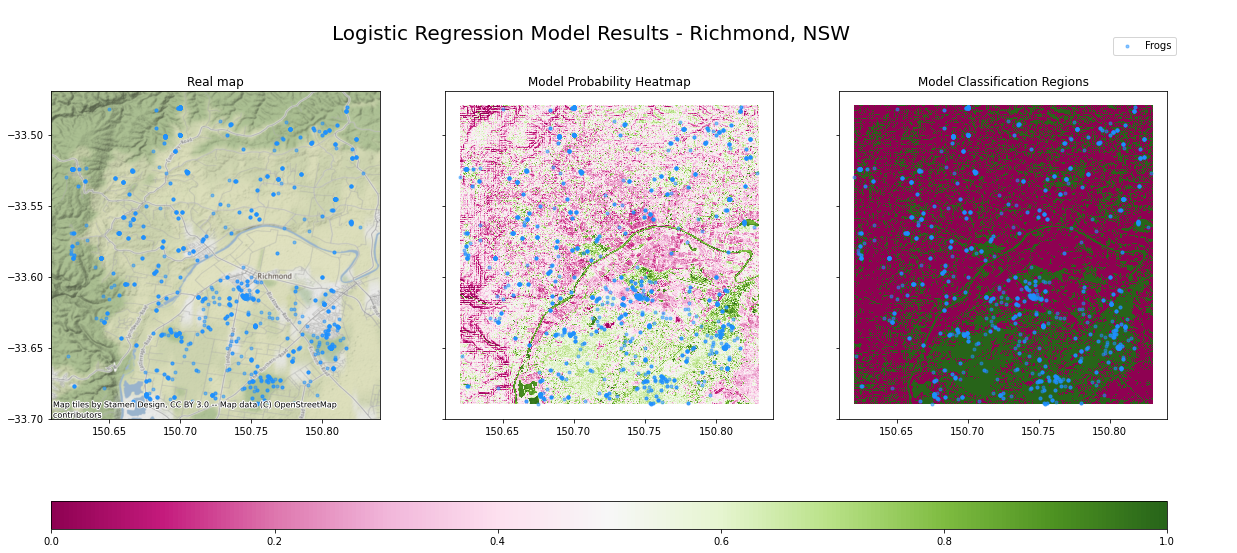

In [17]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    
    bbox = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]

    # Plot real map
    ax[0].scatter(x=[bbox[0], bbox[1]], y=[bbox[2], bbox[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')

    # Plot heatmap from model
    heatmap = ax[1].imshow(
        resultant_image.transpose(), cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox
    )
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = ax[2].imshow(
        resultant_image.transpose() > 0.5, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox
    )
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, color = 'dodgerblue', marker='.', alpha=0.5, label='Frogs' if i==0 else '')

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    

plot_heatmap(resultant_image, frog_data, "Logistic Regression Model Results - Richmond, NSW")

#### In-Sample Evaluation

Now that we have visualised the model on the Richmond area, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance -  so don't get too excited!


In [18]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

predictions = full_model.predict(X)

print(f"F1 Score: {f1_score(y, predictions)}")
print(f"Accuracy: {accuracy_score(y, predictions)}")

F1 Score: 0.6655484736665549
Accuracy: 0.6576236263736264


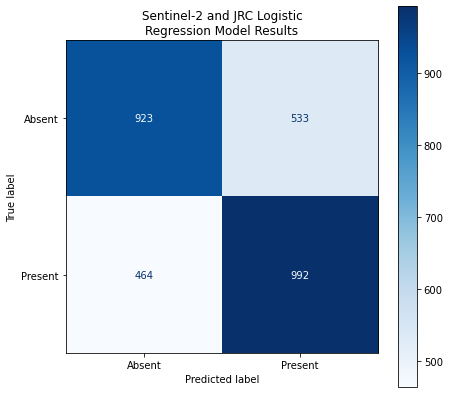

In [19]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Sentinel-2 and JRC Logistic\nRegression Model Results')
plt.show()

#### Out-of-sample evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.


In [20]:
from sklearn.model_selection import StratifiedKFold

cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        results[metric].append(fn(y_test, predictions))
        
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in results.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.66
Accuracy: 0.66


### Testing model on an arbitrary area 

Now that we have generated a model using data from one area, how do we apply that model to other areas? To do this, we need to write some functions that will allow us to automatically pull the required data for an arbitrary location. Specifically, we need to be able to pull all the predictor variables for a given location, as well as the actual frog sightings in that location for reference. These functions will reuse much of the code from prior notebooks, so we won't go into too much detail.


#### Query the Hornsby Area

For this, we will use Hornsby, NSW as an example.

Text(0.5, 1.0, 'Berowra Valley National Park, Hornsby NSW')

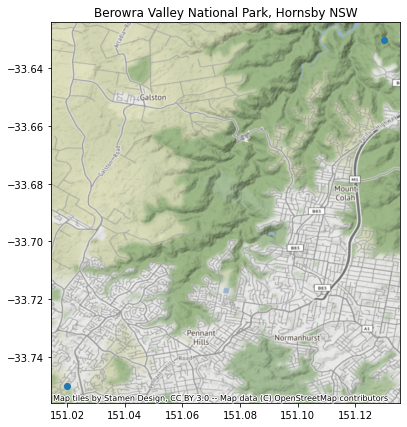

In [21]:
# Hornsby
min_lon, min_lat = (151.02, -33.75)  # Lower-left corner
max_lon, max_lat = (151.13, -33.63)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)


fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat])
cx.add_basemap(ax, crs=crs)
ax.set_title("Berowra Valley National Park, Hornsby NSW")

Firstly, we grab all frog occurrences in the area from 1800 until 2022.

In [22]:
hornsby_frogs = get_frogs(bbox, {"year":"1800,2022"}, verbose=True)

0 of 3001
300 of 3001
600 of 3001
900 of 3001
1200 of 3001
1500 of 3001
1800 of 3001
2100 of 3001
2400 of 3001
2700 of 3001
3000 of 3001


Next, we obtain the predictor variables from the planetary computer.

In [23]:
# Define products and query parameters for the planetary computer
hornsby_datasets = get_predictor_datasets(products, bbox)

loading cop-dem-glo-30
This is the number of scenes that touch our region: 1
loading terraclimate
loading io-lulc
This is the number of scenes that touch our region: 2
loading jrc-gsw
This is the number of scenes that touch our region: 1
loading sentinel-2-l2a
This is the number of scenes that touch our region: 49


Finally, we can use the `create_predictor_image` and `predict_frogs` functions from before to create the probability heatmap of the new area.

In [24]:
hornsby_predictor_image = create_predictor_image(hornsby_datasets)
hornsby_resultant_image = predict_frogs(hornsby_predictor_image, full_model)

Combining dataset 1 of 6
Combining dataset 2 of 6
Combining dataset 3 of 6
Combining dataset 4 of 6
Combining dataset 5 of 6
Combining dataset 6 of 6


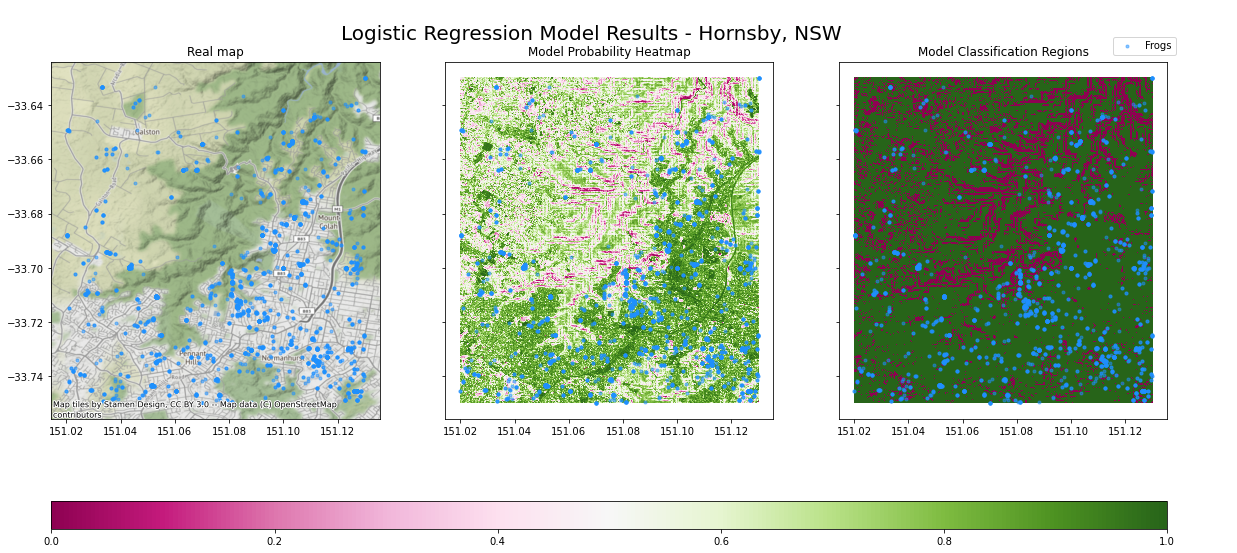

In [25]:
# Display the image
plot_heatmap(hornsby_resultant_image, hornsby_frogs, "Logistic Regression Model Results - Hornsby, NSW")